# Final HAPI Prediction Model (Baseline)

## Description
This script merges all feature engineering outputs into a single analytic dataset and trains a Random Forest classifier to predict Hospital-Acquired Pressure Injuries (HAPI).

## Clinical Justification for Model Selection
* **Algorithm:** Random Forest was selected for its ability to handle non-linear relationships and interactions between risk factors.
* **Evaluation:** Due to the class imbalance (HAPIs are rare), we rely on ROC-AUC and Precision-Recall rather than just raw accuracy.

## Inputs & Outputs
* **Inputs:** `hospitalwide_hapi_labels.csv` (Target), plus all feature files (`*_feat.csv`).
* **Output:** Model Performance Metrics (Confusion Matrix, ROC-AUC) and Feature Importance Plot.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve, 
    average_precision_score, 
    PrecisionRecallDisplay
)

In [32]:
# Configuration
BASE_DIR = r"D:\School\5141"

# Dictionary mapping logical names to actual CSV filenames
FEATURE_FILES = {
    "Labels (Target)": "hospitalwide_hapi_labels.csv",
    "Demographics": "demographics_feat.csv",
    "Length of Stay": "los_feat.csv",
    "ICU Transfers": "icu_transfer.csv",
    "I&O Fluids": "io_feat.csv",
    "ICU Procedures": "icu_procedures_feat.csv",
    "Medications & POE": "medications_master_feat.csv",
    "Clinical Notes (NLP)": "feat_notes.csv",
    "Diagnoses (ICD)": "diagnoses_feat.csv",
    "Labs": "labs_feat.csv",
    "Vitals": "vitals_feat.csv"
}

In [33]:
# Utility Functions
def optimize_memory(df):
    """
    Reduces memory usage by downcasting numeric columns.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.float32)
                
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory reduced to: {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% savings)")
    return df

In [34]:
# Assembly Functions

def load_and_merge():
    """
    Merges all feature files into a single matrix.
    """
    
    # Load Labels
    label_filename = FEATURE_FILES["Labels (Target)"]
    label_path = os.path.join(BASE_DIR, label_filename)
    
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"CRITICAL: Labels file missing at {label_path}")
    
    df = pd.read_csv(label_path, usecols=["hadm_id", "HAPI_FINAL"], low_memory=False)
    df["hadm_id"] = df["hadm_id"].astype("Int64")
    
    print(f"Loaded Target Labels. Total Patients: {len(df)}")
    
    # Loop through other files and merge
    for name, filename in FEATURE_FILES.items():
        if name == "Labels (Target)": continue 

        path = os.path.join(BASE_DIR, filename)
        if os.path.exists(path):
            print(f"Merging {name}...")
            new_df = pd.read_csv(path, low_memory=False)
            
            if "hadm_id" in new_df.columns:
                new_df["hadm_id"] = new_df["hadm_id"].astype("Int64")
                
                cols_to_use = new_df.columns.difference(df.columns).tolist()
                cols_to_use.append("hadm_id")
                
                df = df.merge(new_df[cols_to_use], on="hadm_id", how="left")
                
                del new_df
                gc.collect()
                df = optimize_memory(df)
            else:
                print(f"WARNING: {filename} missing 'hadm_id'. Skipping.")
        else:
            print(f"NOTE: {filename} not found. Skipping.")

    # Fill Missing Values
    print("Imputing missing values with 0...")
    df.fillna(0, inplace=True)
    
    return df

In [35]:
# Visualization Functions
def plot_precision_recall(model, X_test, y_test):
    """
    Generates and plots the Precision-Recall Curve.
    """
    
    # Get probabilities for the positive class (HAPI)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate Average Precision 
    avg_precision = average_precision_score(y_test, y_prob)
    print(f"Average Precision (AP): {avg_precision:.4f}")
    
    plt.figure(figsize=(8, 6))
    display = PrecisionRecallDisplay.from_predictions(
        y_test, 
        y_prob, 
        name="Random Forest",
        color="#6a0dad"
    )
    plt.title(f"Precision-Recall Curve (AP={avg_precision:.2f})")
    plt.plot([0, 1], [1, 0], linestyle="--", color="gray", label="Random Chance")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

In [36]:
# Model Training and Evaluation
def train_and_evaluate(df):
    """
    Trains Random Forest and evaluates performance with HUMAN-READABLE plots.
    """
       
    target_col = "HAPI_FINAL"
    X_cols = [c for c in df.columns if c not in ["hadm_id", "subject_id", target_col]]
    
    X = df[X_cols]
    y = df[target_col]
    
    print(f"Features: {X.shape[1]}")
    print(f"Target Distribution:\n{y.value_counts()}")
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    del df
    gc.collect()
    
    print("\nRandom Forest Model")
    rf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
        verbose=0  
    )
    
    rf.fit(X_train, y_train)
    
    # Evaluation
    print("\n--- Model Evaluation ---")
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC-AUC Score: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (AUC = {auc:.2f})")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    
    # Get the raw code names
    raw_names = [X.columns[i] for i in indices]
    
    # Define the Dictionary to translate Code to HUMAN-READABLE
    feature_map = {
        "LOS_DAYS": "Hospital Length of Stay (Days)",
        "LOS_HOURS": "Hospital Length of Stay (Hours)",
        "num_detail_items": "Nursing Charting Volume",
        "num_prescriptions": "Total Prescriptions Count",
        "age": "Patient Age",
        "total_meds_orders": "Total Medication Orders",
        "num_pharm_orders": "Pharmacy Order Count",
        "num_labs": "Total Lab Tests",
        "num_abnormal_labs": "Abnormal Lab Results Count",
        "num_distinct_pharm_meds": "Distinct Pharmacy Meds",
        "num_distinct_drugs": "Distinct Drug Classes",
        "total_meds_admin": "Total Meds Administered",
        "num_meds_admin": "Medication Admin Events",
        "num_distinct_meds": "Distinct Meds Administered",
        "num_high_risk_drugs": "High-Risk Meds (Sedatives/Vasopressors)",
        "nutrition_bad": "Malnutrition Risk (Clinical Notes)",
        "immobility": "Immobility Indicators (Clinical Notes)",
        "total_input_ml": "Total Fluid Intake (mL)",
        "num_icu_procedures_0_48h": "Early ICU Procedures (0-48h)",
        "num_high_risk_pharm_orders": "High-Risk Pharmacy Orders"
    }
    
    # Apply mapping
    clean_labels = [feature_map.get(name, name) for name in raw_names]
    
    plt.figure(figsize=(12, 10))
    plt.title("Top 20 Predictors of Hospital-Acquired Pressure Injuries", fontsize=16)
    plt.barh(range(20), importances[indices], align="center", color="#2c3e50")
    plt.yticks(range(20), clean_labels, fontsize=12)
    plt.gca().invert_yaxis()
    plt.xlabel("Relative Importance", fontsize=12)
    plt.tight_layout()
    plt.show()

    return rf, X_test, y_test

Loaded Target Labels. Total Patients: 546028
Merging Demographics...
Memory reduced to: 4.69 MB (81.6% savings)
Merging Length of Stay...
Memory reduced to: 8.85 MB (32.0% savings)
Merging ICU Transfers...
Memory reduced to: 15.10 MB (29.3% savings)
Merging I&O Fluids...
Memory reduced to: 21.35 MB (22.6% savings)
Merging ICU Procedures...
Memory reduced to: 40.45 MB (31.9% savings)
Merging Medications & POE...
Memory reduced to: 103.49 MB (37.9% savings)
Merging Clinical Notes (NLP)...
Memory reduced to: 111.89 MB (7.0% savings)
Merging Diagnoses (ICD)...
Memory reduced to: 153.92 MB (21.4% savings)
Merging Labs...
Memory reduced to: 160.23 MB (3.8% savings)
Merging Vitals...
Memory reduced to: 183.34 MB (11.2% savings)
Imputing missing values with 0...
Features: 89
Target Distribution:
HAPI_FINAL
0    411313
1    139533
Name: count, dtype: int64

Random Forest Model

--- Model Evaluation ---

ROC-AUC Score: 0.8042

Classification Report:
              precision    recall  f1-score   

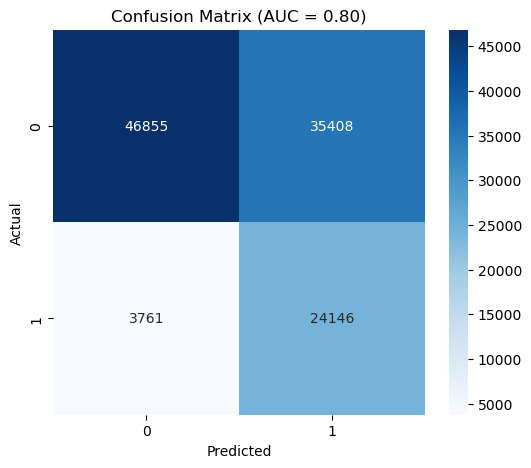

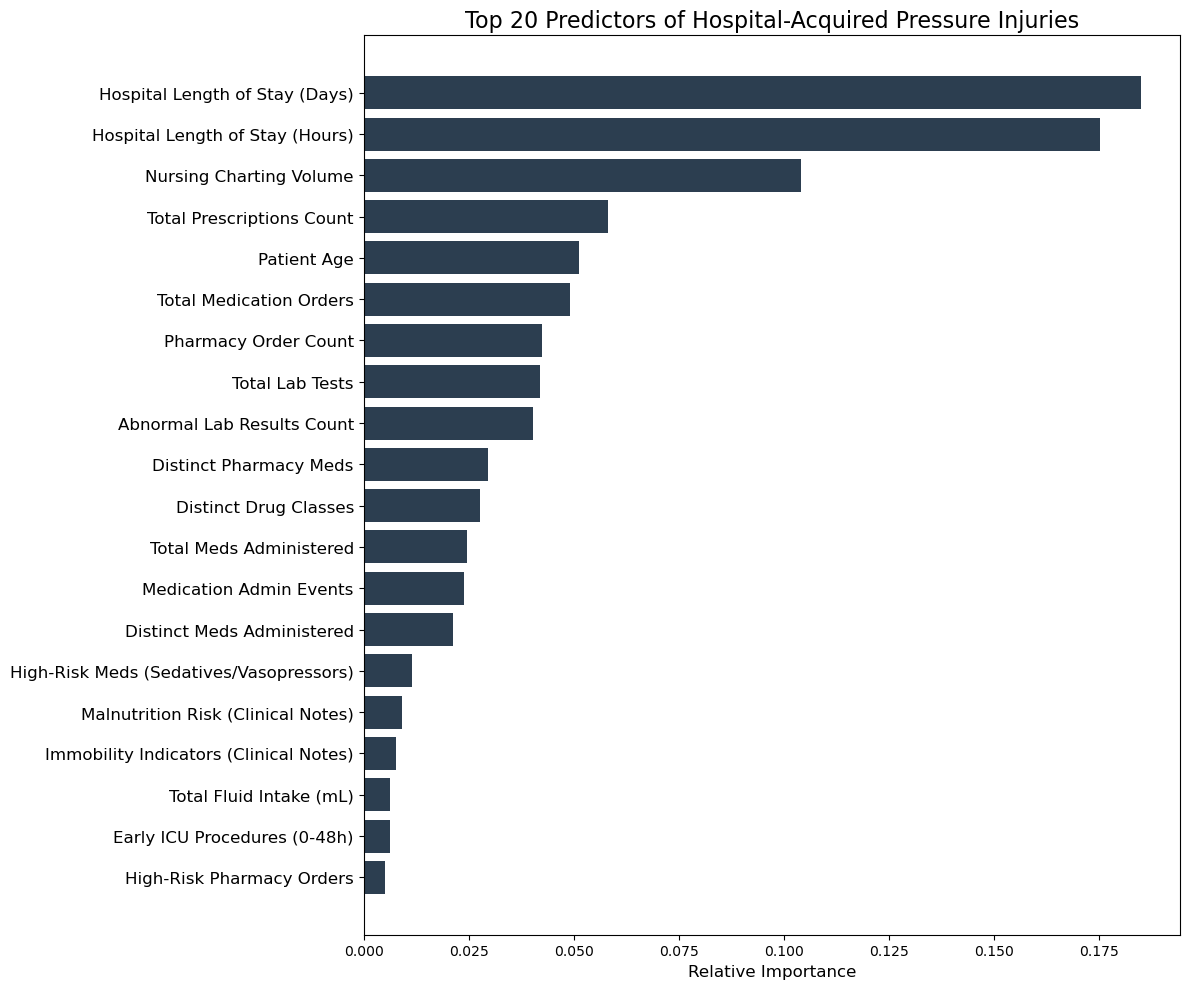

Average Precision (AP): 0.5748


<Figure size 800x600 with 0 Axes>

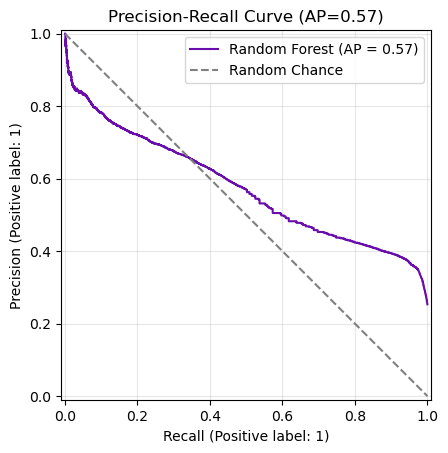

In [37]:
# Execute 
if __name__ == "__main__":
    full_dataset = load_and_merge()
    rf_model, X_test_data, y_test_data = train_and_evaluate(full_dataset)
    plot_precision_recall(rf_model, X_test_data, y_test_data)